# Nous: A Complete Demonstration
#
This notebook provides a comprehensive tutorial and showcase of the `nous` library. It covers:
1.  **Installation** directly from GitHub.
2.  **Training** models for **classification** (Wine dataset).
3.  **A deep dive into every interpretation function** in the `nous.interpret` module.
4.  **A showcase of the causal analysis module** for a classification task.
5.  **A full showcase for a regression task**, including training, interpretation, and causal analysis.

In [9]:
# ==============================================================================
# Section 1: Installation & Imports
# ==============================================================================

# --- 1. Installation ---
!pip install git+https://github.com/EmotionEngineer/nous.git -q

# --- 2. Imports ---
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification, load_wine, make_regression
from sklearn.metrics import r2_score
from typing import List
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import copy, warnings

# --- Environment Setup ---
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_theme(style="whitegrid")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 3. Import from nous library ---
try:
    from nous.models import NousNet
    from nous.interpret import trace_decision_graph, explain_fact, plot_logic_graph, plot_fact_activation_function, plot_final_layer_contributions
    from nous.causal import find_counterfactual
    print("`nous` library imported successfully!")
except ImportError as e:
    raise ImportError(f"Could not import from nous. Please ensure the installation was successful.\nOriginal error: {e}")

ERROR: git+https://github.com/EmotionEngineer/nous.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Using device: cpu
`nous` library imported successfully!


## Section 2: Utilities for Training and Data Handling
#
Helper functions to streamline training and evaluation for both classification and regression.

In [10]:
# ==============================================================================
# Section 2: Utilities for Training and Data Handling
# ==============================================================================

def get_data_split(X, y, task='classification'):
    """Splits data and converts to tensors for classification or regression."""
    stratify_opt = y if task == 'classification' else None
    
    # First split: 80% for training/validation, 20% for testing
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=stratify_opt
    )
    
    # Second split: split the 80% into training (60%) and validation (20%)
    stratify_opt_2 = y_train_val if task == 'classification' else None
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=stratify_opt_2
    )
    
    y_dtype = torch.long if task == 'classification' else torch.float32
    y_train_tensor = torch.tensor(y_train, dtype=y_dtype).to(DEVICE)
    y_val_tensor = torch.tensor(y_val, dtype=y_dtype).to(DEVICE)
    y_test_tensor = torch.tensor(y_test, dtype=y_dtype).to(DEVICE)

    # For binary classification and regression, ensure y has shape [N, 1]
    is_binary_clf = task == 'classification' and len(np.unique(y)) == 2
    if is_binary_clf:
        y_train_tensor = y_train_tensor.float().unsqueeze(1)
        y_val_tensor = y_val_tensor.float().unsqueeze(1)
        y_test_tensor = y_test_tensor.float().unsqueeze(1)
    elif task == 'regression':
        y_train_tensor = y_train_tensor.unsqueeze(1)
        y_val_tensor = y_val_tensor.unsqueeze(1)
        y_test_tensor = y_test_tensor.unsqueeze(1)
        
    datasets = {
        "train": (torch.tensor(X_train, dtype=torch.float32).to(DEVICE), y_train_tensor),
        "val": (torch.tensor(X_val, dtype=torch.float32).to(DEVICE), y_val_tensor),
        "test": (torch.tensor(X_test, dtype=torch.float32).to(DEVICE), y_test_tensor)
    }
    return datasets

def train_model(model, datasets, loss_fn, epochs=100, patience=15, model_name=""):
    """Robust training loop for any task."""
    model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
    (X_train, y_train), (X_val, y_val) = datasets['train'], datasets['val']
    loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    best_val_loss = float('inf'); patience_counter = 0; best_model_state = None
    pbar = tqdm(range(epochs), desc=f"Training {model_name}", leave=False)
    for epoch in pbar:
        model.train()
        for X_batch, y_batch in loader:
            optimizer.zero_grad(); pred = model(X_batch); loss = loss_fn(pred, y_batch)
            loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0); optimizer.step()
        model.eval()
        with torch.no_grad(): val_loss = loss_fn(model(X_val), y_val)
        pbar.set_postfix({"val_loss": f"{val_loss.item():.4f}"})
        if torch.isnan(val_loss): print("NaN loss detected, stopping."); break
        if val_loss < best_val_loss:
            best_val_loss, patience_counter, best_model_state = val_loss, 0, copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1
        if patience_counter >= patience: pbar.close(); print(f"  > Early stopping at epoch {epoch + 1}."); break
    if best_model_state: model.load_state_dict(best_model_state)
    return model

# Simple MLP for baseline comparison
class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int], output_dim: int = 1):
        super().__init__()
        layers, current_dim = [], input_dim
        for h_dim in hidden_dims: layers.extend([nn.Linear(current_dim, h_dim), nn.ReLU(), nn.Dropout(0.3)]); current_dim = h_dim
        layers.append(nn.Linear(current_dim, output_dim)); self.network = nn.Sequential(*layers)
    def forward(self, x: torch.Tensor) -> torch.Tensor: return self.network(x)

## Section 3: Classification Showcase (Wine Dataset)
#
First, we train all three `NousNet` variants and an MLP baseline on the real-world Wine dataset to compare their performance.

## Part 1: Classification Showcase (Wine Dataset)


--- Training NousNet (beta) on Wine Dataset ---


Training NousNet (beta):   0%|          | 0/200 [00:00<?, ?it/s]

  > Early stopping at epoch 78.
  > Final Test Accuracy: 97.22%

--- Training NousNet (sigmoid) on Wine Dataset ---


Training NousNet (sigmoid):   0%|          | 0/200 [00:00<?, ?it/s]

  > Final Test Accuracy: 100.00%

--- Training NousNet (exhaustive) on Wine Dataset ---


Training NousNet (exhaustive):   0%|          | 0/200 [00:00<?, ?it/s]

  > Early stopping at epoch 38.
  > Final Test Accuracy: 100.00%

--- Training MLP Baseline on Wine Dataset ---


Training MLP Baseline:   0%|          | 0/200 [00:00<?, ?it/s]

  > Early stopping at epoch 41.
  > Final Test Accuracy: 97.22%


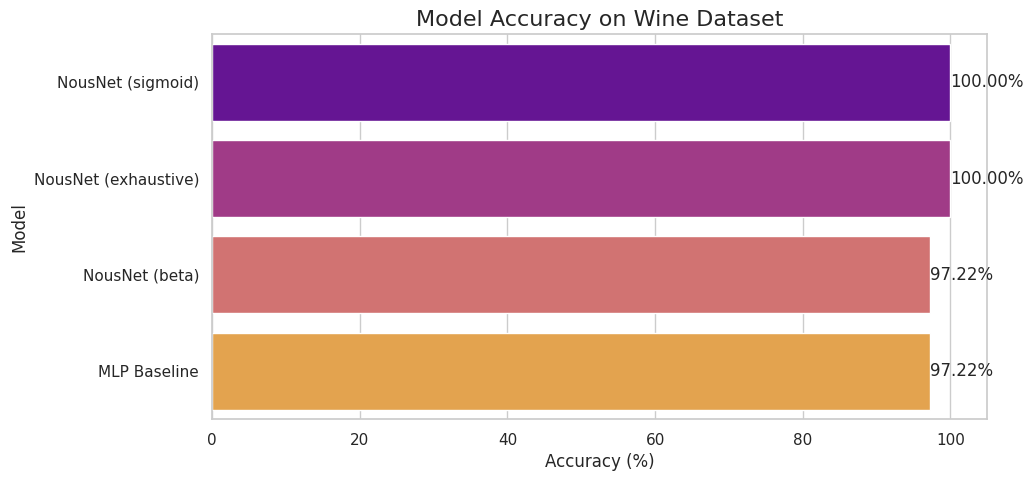

In [11]:
# ==============================================================================
# Section 3: Classification Showcase (Wine Dataset)
# ==============================================================================

display(Markdown("## Part 1: Classification Showcase (Wine Dataset)"))

# --- 1. Get Data ---
wine = load_wine()
X_raw, y_raw = wine.data, wine.target
feature_names_wine = [name.replace(" ", "_").replace("/", "_") for name in wine.feature_names]
X_wine = StandardScaler().fit_transform(X_raw)
datasets_wine = get_data_split(X_wine, y_raw, task='classification')
INPUT_DIM_WINE, OUTPUT_DIM_WINE = X_wine.shape[1], len(set(y_raw))

# --- 2. Define Models ---
models_to_train_clf = {
    "NousNet (beta)": NousNet(input_dim=INPUT_DIM_WINE, output_dim=OUTPUT_DIM_WINE, feature_names=feature_names_wine, fact_layer_type='beta'),
    "NousNet (sigmoid)": NousNet(input_dim=INPUT_DIM_WINE, output_dim=OUTPUT_DIM_WINE, feature_names=feature_names_wine, fact_layer_type='sigmoid'),
    "NousNet (exhaustive)": NousNet(input_dim=INPUT_DIM_WINE, output_dim=OUTPUT_DIM_WINE, feature_names=feature_names_wine, fact_layer_type='exhaustive'),
    "MLP Baseline": MLP(input_dim=INPUT_DIM_WINE, hidden_dims=[32, 16], output_dim=OUTPUT_DIM_WINE),
}

# --- 3. Train and Evaluate ---
loss_fn_multi = nn.CrossEntropyLoss()
trained_models_wine = {}
results_wine = {}
for name, model in models_to_train_clf.items():
    print(f"\n--- Training {name} on Wine Dataset ---")
    trained_model = train_model(model, datasets_wine, loss_fn_multi, epochs=200, patience=25, model_name=name)
    with torch.no_grad(): preds = torch.argmax(trained_model(datasets_wine['test'][0]), dim=1)
    accuracy = (preds == datasets_wine['test'][1]).float().mean().item()
    trained_models_wine[name] = trained_model
    results_wine[name] = accuracy
    print(f"  > Final Test Accuracy: {accuracy:.2%}")

# --- 4. Display Results ---
df_results_wine = pd.DataFrame(list(results_wine.items()), columns=['Model', 'Accuracy']); df_results_wine['Accuracy_pct'] = df_results_wine['Accuracy'] * 100
plt.figure(figsize=(10, 5)); ax = sns.barplot(x='Accuracy_pct', y='Model', data=df_results_wine.sort_values('Accuracy', ascending=False), palette='plasma')
plt.title("Model Accuracy on Wine Dataset", fontsize=16); plt.xlabel("Accuracy (%)")
for c in ax.containers: ax.bar_label(c, fmt='%.2f%%')
plt.show()

## Section 4: Full Interpretation Showcase
#
This section demonstrates every major function from the `nous.interpret` module, using the best-performing `NousNet` model trained above.

## Part 2: A Deep Dive into `nous` Interpretation Tools

Analyzing a sample from the Wine test set.
- **True Class:** `0`
- **Predicted Class:** `0`


### 1. `trace_decision_graph`

#### Top 3 Activations for: **Atomic Facts**

,Node,Activation
0,Beta-24(flavanoids vs alcalinity_of_ash),0.961166
1,Beta-3(alcohol vs proline),0.957909
2,Beta-22Thresh(hue),0.940621


#### Top 3 Activations for: **Rules L0**

,Node,Activation
0,(Beta-12(color_intensity vs proline) AND Beta-4(ash vs malic_acid)),0.365739
1,(Beta-17(od280_od315_of_diluted_wines vs total_phenols) AND Beta-16(total_phenols vs malic_acid)),0.294444
2,(Beta-1Thresh(flavanoids) AND Beta-21(proline vs hue)),0.128793


#### Top 3 Activations for: **Concepts L0**

,Node,Activation
0,Concept-0,0.577723
1,Concept-6,0.574971
2,Concept-1,0.548103


#### Top 3 Activations for: **Rules L1**

,Node,Activation
0,(Concept-9 AND Concept-9),3.048871
1,(Concept-7 AND Concept-4),2.541893
2,(Concept-4 AND Concept-1),1.336830


#### Top 3 Activations for: **Concepts L1**

,Node,Activation
0,Concept-4,0.959632
1,Concept-2,0.955468
2,Concept-1,0.470500



### 2. `explain_fact` & `plot_fact_activation_function`

Decoding the most activated fact: **'Beta-24(flavanoids vs alcalinity_of_ash)'**.

Explanation for fact 'Beta-24(flavanoids vs alcalinity_of_ash)':
Fact is TRUE when: (Sum(left_weight * feat) - Sum(right_weight * feat)) > -0.325


,feature,left_weight,right_weight,net_effect
6,flavanoids,0.558176,-0.046438,0.604614
9,color_intensity,-0.213939,0.347908,-0.561847
10,hue,0.184894,-0.298614,0.483508
11,od280_od315_of_diluted_wines,0.339778,-0.123788,0.463566
4,magnesium,-0.317560,0.131534,-0.449094
3,alcalinity_of_ash,-0.045696,0.367218,-0.412914
7,nonflavanoid_phenols,0.287416,-0.079922,0.367338
8,proanthocyanins,0.076824,-0.259190,0.336013
12,proline,0.028900,-0.266570,0.295469
5,total_phenols,-0.158970,-0.010473,-0.148498


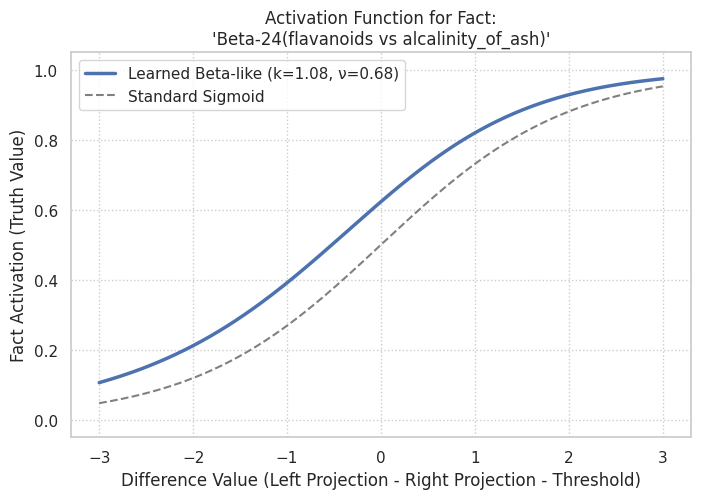


### 3. `plot_final_layer_contributions`

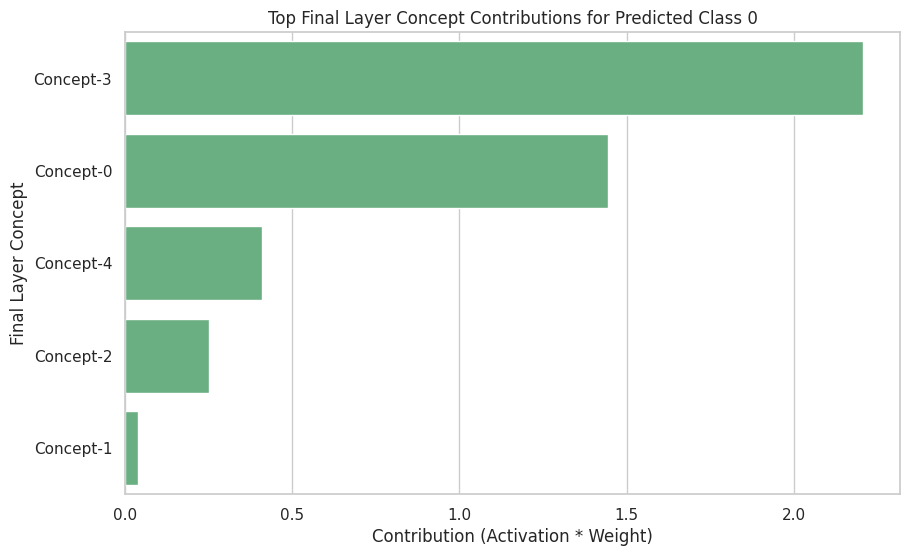

In [12]:
# ==============================================================================
# Section 4: Full Interpretation Showcase
# ==============================================================================

display(Markdown("## Part 2: A Deep Dive into `nous` Interpretation Tools"))
model_to_interpret_clf = trained_models_wine["NousNet (beta)"]
x_sample_clf, y_true_clf = datasets_wine['test'][0][5], datasets_wine['test'][1][5].item()
with torch.no_grad(): y_pred_clf = model_to_interpret_clf(x_sample_clf.unsqueeze(0)).argmax().item()
display(Markdown(f"Analyzing a sample from the Wine test set.\n- **True Class:** `{y_true_clf}`\n- **Predicted Class:** `{y_pred_clf}`"))

# --- 1. `trace_decision_graph` ---
display(Markdown("\n### 1. `trace_decision_graph`"))
graph_data_clf = trace_decision_graph(model_to_interpret_clf, x_sample_clf)
# Display top 3 activations per level
for level, nodes in graph_data_clf['trace'].items():
    display(Markdown(f"#### Top 3 Activations for: **{level}**"))
    sorted_nodes = sorted(nodes.items(), key=lambda i: abs(i[1]['value']), reverse=True)
    df = pd.DataFrame([{"Node": name, "Activation": data['value']} for name, data in sorted_nodes[:3]])
    display(df.style.bar(subset=['Activation'], align='mid', color=['#d65f5f', '#5fba7d']))

# --- 2. `explain_fact` & `plot_fact_activation_function` ---
display(Markdown("\n### 2. `explain_fact` & `plot_fact_activation_function`"))
fact_to_analyze_clf = sorted(graph_data_clf['trace']['Atomic Facts'].items(), key=lambda i: i[1]['value'], reverse=True)[0][0]
display(Markdown(f"Decoding the most activated fact: **'{fact_to_analyze_clf}'**."))
explanation_df_clf = explain_fact(model_to_interpret_clf, fact_name=fact_to_analyze_clf); display(explanation_df_clf)
plot_fact_activation_function(model_to_interpret_clf, fact_name=fact_to_analyze_clf)

# --- 3. `plot_final_layer_contributions` ---
display(Markdown("\n### 3. `plot_final_layer_contributions`"))
plot_final_layer_contributions(model_to_interpret_clf, x_sample_clf)

## Section 5: Causal Analysis Showcase (Classification)

In [13]:
# ==============================================================================
# Section 5: Causal Analysis Showcase (Classification)
# ==============================================================================

display(Markdown("## Part 3: Causal Analysis (Classification)"))
# --- 1. Train a simple binary model for a credit scoring scenario ---
X_raw_bin, y_raw_bin = make_classification(n_samples=500, n_features=5, n_informative=3, random_state=1)
feature_names_bin, X_bin = ['income', 'debt_ratio', 'age', 'credit_history', 'loan_term'], StandardScaler().fit_transform(X_raw_bin)
datasets_bin = get_data_split(X_bin, y_raw_bin, task='classification')
causal_model = NousNet(input_dim=5, output_dim=1, feature_names=feature_names_bin, fact_layer_type='beta')
causal_model = train_model(causal_model, datasets_bin, nn.BCEWithLogitsLoss(), epochs=50, patience=10, model_name="Causal Model")

# --- 2. Find a sample that was "denied" (prediction > 0.5) ---
X_test_bin, _ = datasets_bin['test']
with torch.no_grad(): preds_bin = torch.sigmoid(causal_model(X_test_bin))
denied_indices = (preds_bin > 0.7).squeeze().nonzero()
if len(denied_indices) == 0: denied_indices = (preds_bin > 0.5).squeeze().nonzero()
if len(denied_indices) == 0: raise RuntimeError("No samples classified as positive found.")
x_denied_sample = X_test_bin[denied_indices[0].item()]
initial_risk = torch.sigmoid(causal_model(x_denied_sample.unsqueeze(0))).item()
display(Markdown(f"Found a sample with a high predicted risk of **{initial_risk:.2%}**. Let's find out how to get them approved.")); display(pd.DataFrame([x_denied_sample.cpu().numpy()], columns=feature_names_bin))

# --- 3. Use `find_counterfactual` to get a recommendation ---
display(Markdown("\n**Query:** What is the smallest change to reduce the risk below 40%?"))
recommendation = find_counterfactual(causal_model, x_denied_sample, target_output=0.40, task='classification', l1_lambda=0.01)
if not recommendation['changes']: print("No simple change found.")
else:
    print("\n**Recommendation:**"); [print(f"- Change '{f}' from {o:.2f} to {n:.2f}") for f, o, n in recommendation['changes']]
    with torch.no_grad(): new_risk = torch.sigmoid(causal_model(recommendation['counterfactual_x'].unsqueeze(0))).item()
    print(f"\n**Verification:** New predicted risk is **{new_risk:.2%}**.")

## Part 3: Causal Analysis (Classification)

Training Causal Model:   0%|          | 0/50 [00:00<?, ?it/s]

Found a sample with a high predicted risk of **99.43%**. Let's find out how to get them approved.

,income,debt_ratio,age,credit_history,loan_term
0,0.790922,0.742817,-1.501725,0.687486,-0.986317



**Query:** What is the smallest change to reduce the risk below 40%?


**Recommendation:**
- Change 'income' from 0.79 to 0.30
- Change 'debt_ratio' from 0.74 to 0.37
- Change 'age' from -1.50 to -0.27
- Change 'credit_history' from 0.69 to 0.31
- Change 'loan_term' from -0.99 to -0.00

**Verification:** New predicted risk is **40.02%**.


## Section 6: Regression Showcase
#
Now we demonstrate `nous`'s capabilities on a regression task, including training, interpretation, and causal analysis.

## Part 4: Regression Showcase (House Price Prediction)

Training Regression Model:   0%|          | 0/200 [00:00<?, ?it/s]

  > Early stopping at epoch 76.
  > Final Test R² Score: 0.845



Analyzing a sample from the regression test set.
- **True Value:** `117.21`
- **Predicted Value:** `83.19`

The `plot_final_layer_contributions` function shows which concepts added to or subtracted from the final value:

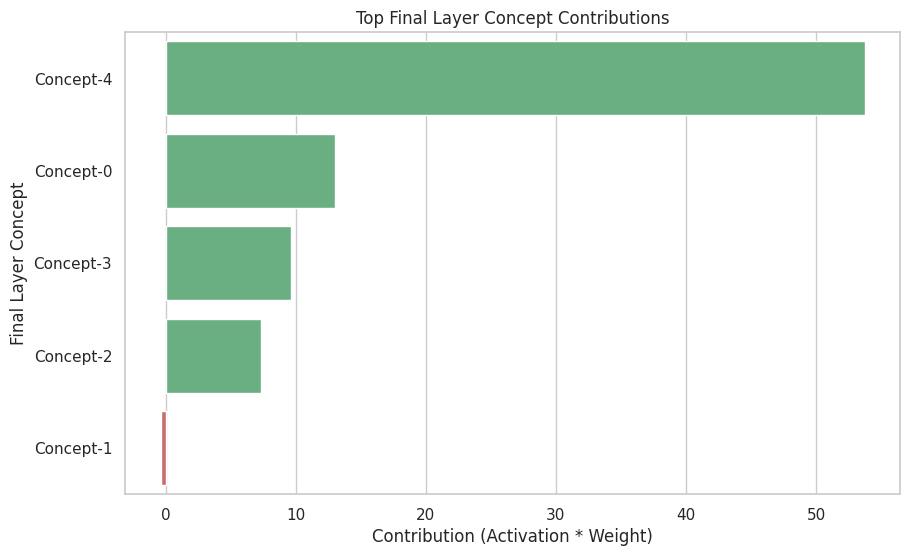


**Query:** What is the smallest change to increase the predicted value by 50?


**Recommendation:**
- Change 'area_sqft' from 0.14 to 0.70
- Change 'num_bedrooms' from 0.46 to 0.96
- Change 'dist_to_center' from -0.64 to -0.10
- Change 'age_years' from -0.40 to 0.18
- Change 'quality_score' from 2.00 to 2.56

**Verification:** New predicted value is **106.82** (Target was 133.19).


In [15]:
# ==============================================================================
# Section 6: Regression Showcase
# ==============================================================================
display(Markdown("## Part 4: Regression Showcase (House Price Prediction)"))

# --- 1. Get Data ---
X_raw_reg, y_raw_reg = make_regression(n_samples=1000, n_features=5, n_informative=4, noise=25, random_state=42)
feature_names_reg = ['area_sqft', 'num_bedrooms', 'dist_to_center', 'age_years', 'quality_score']
X_reg = StandardScaler().fit_transform(X_raw_reg)
datasets_reg = get_data_split(X_reg, y_raw_reg, task='regression')

# --- 2. Train a NousNet for Regression ---
model_reg = NousNet(input_dim=5, output_dim=1, feature_names=feature_names_reg, fact_layer_type='beta')
loss_fn_reg = nn.MSELoss()
model_reg = train_model(model_reg, datasets_reg, loss_fn_reg, epochs=200, patience=25, model_name="Regression Model")
with torch.no_grad():
    preds_reg = model_reg(datasets_reg['test'][0])
    r2 = r2_score(datasets_reg['test'][1].cpu(), preds_reg.cpu())
print(f"  > Final Test R² Score: {r2:.3f}")

# --- 3. Interpret a Regression Prediction ---
x_sample_reg, y_true_reg = datasets_reg['test'][0][10], datasets_reg['test'][1][10].item()
with torch.no_grad(): pred_val_reg = model_reg(x_sample_reg.unsqueeze(0)).item()
display(Markdown(f"\nAnalyzing a sample from the regression test set.\n- **True Value:** `{y_true_reg:.2f}`\n- **Predicted Value:** `{pred_val_reg:.2f}`"))
display(Markdown("The `plot_final_layer_contributions` function shows which concepts added to or subtracted from the final value:"))
plot_final_layer_contributions(model_reg, x_sample_reg)

# --- 4. Causal Analysis for Regression ---
display(Markdown("\n**Query:** What is the smallest change to increase the predicted value by 50?"))
target_value = pred_val_reg + 50.0
recommendation_reg = find_counterfactual(model_reg, x_sample_reg, target_output=target_value, task='regression', l1_lambda=0.01)
if not recommendation_reg['changes']: print("No simple change found.")
else:
    print("\n**Recommendation:**"); [print(f"- Change '{f}' from {o:.2f} to {n:.2f}") for f, o, n in recommendation_reg['changes']]
    with torch.no_grad(): new_val = model_reg(recommendation_reg['counterfactual_x'].unsqueeze(0)).item()
    print(f"\n**Verification:** New predicted value is **{new_val:.2f}** (Target was {target_value:.2f}).")